In [1]:
import sys
import os
import torch
from PIL import Image
import time
import matplotlib.pyplot as plt

MUJOCO_ENV_OUTPUT_IMG_DIR = "../data/mujoco_env_output_imgs"
if not os.path.exists(MUJOCO_ENV_OUTPUT_IMG_DIR):
    os.makedirs(MUJOCO_ENV_OUTPUT_IMG_DIR)

current_dir = os.getcwd()
# Navigate up one directory to get the correct path
sys.path.insert(0, os.path.abspath(os.path.join(current_dir, "..", "src")))

# Mujoco Related
from mujoco_env.manipulator_agent import ManipulatorAgent
from utils.interpolation_tools import *

from mllm_module import gpt4v_completion, gpt4v_completion_async, ImageTextConversation, Message
from detection_module.owlv2 import Owlv2
from detection_module.utils import class_agnostic_nms, show_images
import instructor # IMPORTANT :Please install instructor version 1.3.1

### Set `instruction`

In [2]:
instruction = "I am so thirsty after working out. Please hand me something to drink."

### Initialize `Mujoco`

In [3]:
xml_path = "data/assets/ur5e/object_scene.xml"
MODE = 'window' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)

print(env.ctrl_names)
print(env.idxs_step)
# Initail pose
init_joint_value = [-0.7330382, -2.26892803,  1.81514242,  1.57079633, 1.23918377, -0.50614548]
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
env.close_viewer()
print ("Ready.")

MODE: window


2024-06-07 15:50:14.734 Python[53183:16766412] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/fd/4tclvst511lf5fztg9vflt5r0000gn/T/org.python.python.savedState


['shoulder_pan', 'shoulder_lift', 'elbow', 'wrist_1', 'wrist_2', 'wrist_3', 'gripper']
[0, 1, 2, 3, 4, 5]
Ready.


### Gripper Control Function

In [4]:
def step_gripper(env:ManipulatorAgent, command:str="", nstep:int=1):
    if command.lower() == "open":
        env.step(ctrl=[1.25],ctrl_idxs=[6],nstep=nstep)
    elif command.lower() == "close":
        env.step(ctrl=[0],ctrl_idxs=[6],nstep=nstep)
    else:
        env.step()

### Render PCD?

In [5]:
#RENDER_PCD = True
RENDER_PCD = False

### Get projection of pcd for xy plane 

MODE: window


2024-06-07 15:50:17.236 Python[53183:16766412] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


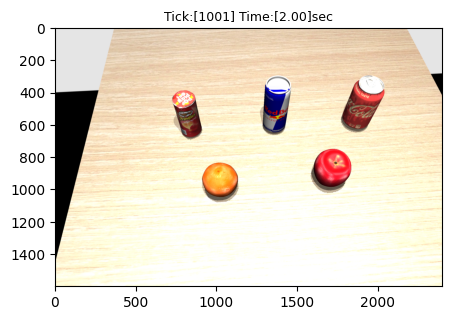

In [6]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
p_time = env.get_p_body('ur_base')
p_time[2] += 0.5
t_s = time.perf_counter()
t_sim_start = t_s
while env.is_viewer_alive():

    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=init_joint_value, ctrl_idxs=env.idxs_step)
        step_gripper(env,command="open")
        
    if time.perf_counter() - t_s >= render_dt:
        t_s += render_dt
        env.plot_T(p=env.get_p_body('ur_base'),R=env.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=p_time,R=env.get_R_body('ur_base'),label="simtime=[%.1f],realtime=[%.1f]"%(env.get_sim_time(),time.perf_counter()-t_sim_start),PLOT_AXIS=False)
        env.plot_T(p=env.get_p_body('ur_camera_center'),R=env.get_R_body('ur_camera_center'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=env.get_p_body('ur_tcp_link'),R=env.get_R_body('ur_tcp_link'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)

        if RENDER_PCD:
            p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
            p_ego  = p_cam
            p_trgt = p_cam + R_cam[:,2]
            rgb_img,depth_img,pcd,xyz_img,xyz_img_world = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=10,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
            filterd_by_z = pcd[pcd[:, 2] > 0.05]
            table_z = np.min(filterd_by_z, axis=0)[2]
            for i,p in enumerate(pcd):
                if p[2] > table_z+0.03:
                    env.plot_sphere(p=p,r=0.005,rgba=np.array([0, 1, 0, 1]))
        env.render()
    if env.get_sim_time() > 2:
        p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img,xyz_img_world = env.get_egocentric_rgb_depth_pcd(
        p_ego=p_ego,p_trgt=p_trgt,rsz_rate=1,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        # z threashold filter
        filterd_by_z = pcd[pcd[:, 2] > 0.05]
        table_z = np.min(filterd_by_z, axis=0)[2]
        filterd_by_z = pcd[pcd[:, 2] > table_z+0.05] 
        env.render()
        break
# Plot the final scene and egocentric images
plt.figure(figsize=(5,4)); plt.imshow(rgb_img)
plt.imsave(os.path.join(MUJOCO_ENV_OUTPUT_IMG_DIR,"initial_manipulation_scene.png"),rgb_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
plt.close()
env.close_viewer()

## Step 1: Ask `GPT4-V` to find objects in the scene

In [7]:
# Step 1.1 : Define Output Structure of the GPT-4v

from pydantic import BaseModel, Field
from typing import List, Optional

class ObjectsListOutput(BaseModel):
    reasoning: Optional[str] = Field(
        None, description="Concise reasoning for the prediction."
    )
    objects: List[str] = Field(
        ..., description="List of objects in the image."
    )

    # print
    def __str__(self):
        return f"Objects: {self.objects}\nReasoning: {self.reasoning}"

SYSTEM_PROMPT = """
You are an embodied AI agent in a simulated environment. Your main task is to identify objects in the scene.
""".strip()

In [8]:
# Step 1.2 : Define the conversation
conv = ImageTextConversation(
    messages=[
        Message(role="system", text=SYSTEM_PROMPT),
        Message(role="user", text="List the objects names in the scene.", image_path=os.path.join(MUJOCO_ENV_OUTPUT_IMG_DIR,"initial_manipulation_scene.png")),
    ]
)

# Step 1.3 : Run the GPT-4v model
object_list_output_dict = gpt4v_completion(
    conv,
    model="gpt-4o",
    response_model=ObjectsListOutput,
)

print(object_list_output_dict)

Objects: ['Pringles can', 'Red Bull can', 'Coca-Cola can', 'orange', 'apple']
Reasoning: None


# Step2 : Get `Owlv2` detection results from GPT4v output

### Load Image

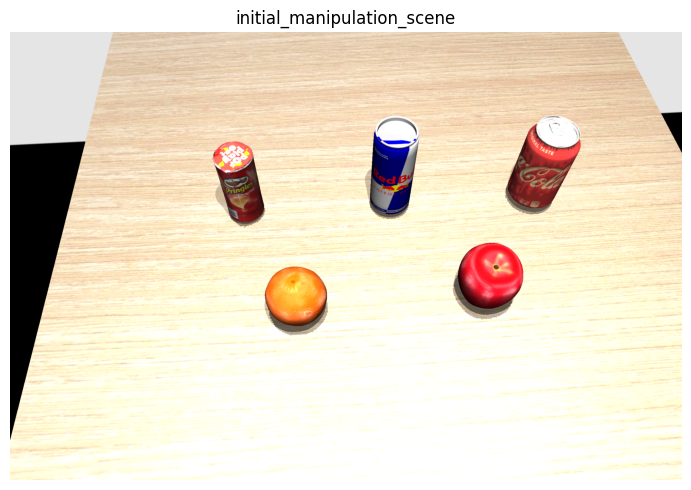

In [9]:
images = [Image.open(os.path.join(MUJOCO_ENV_OUTPUT_IMG_DIR,"initial_manipulation_scene.png")).convert("RGB")]
titles = ["initial_manipulation_scene"]

show_images(images, titles) # Show images

### Get inference from `Owlv2`

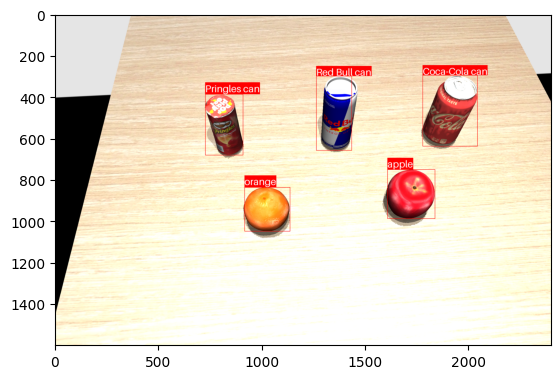

In [10]:
# load model 
owlvit = Owlv2()

sample = {
    'image': images[0],
    'text': object_list_output_dict.objects,
    'box_threshold' : 0.3
}
result = owlvit.detect_objects(**sample)[0]

plt.clf()
_label = [object_list_output_dict.objects[i] for i in result['labels'].tolist()]
label_overlay_img = owlvit.draw_boxes(images[0], result['boxes'], _label)
plt.imshow(label_overlay_img)

## Step3 : Relabel the class with GPT4-V + SoM

In [12]:

class ObjectLabelResponse(BaseModel):
    reasoning: Optional[str] = Field(
        None, description="Detailed reasoning for why the object is labeled as such, based on visible characteristics such as color, shape, text, or logos."
    )
    label: str

SYSTEM_PROMPT_SOM = """
You are an image bounding box labeler for the following images. Please label the objects in the images strictly based on their visible characteristics and features. Avoid assumptions or labels that are not directly supported by the visual evidence in the image.
""".strip()

<Figure size 640x480 with 0 Axes>

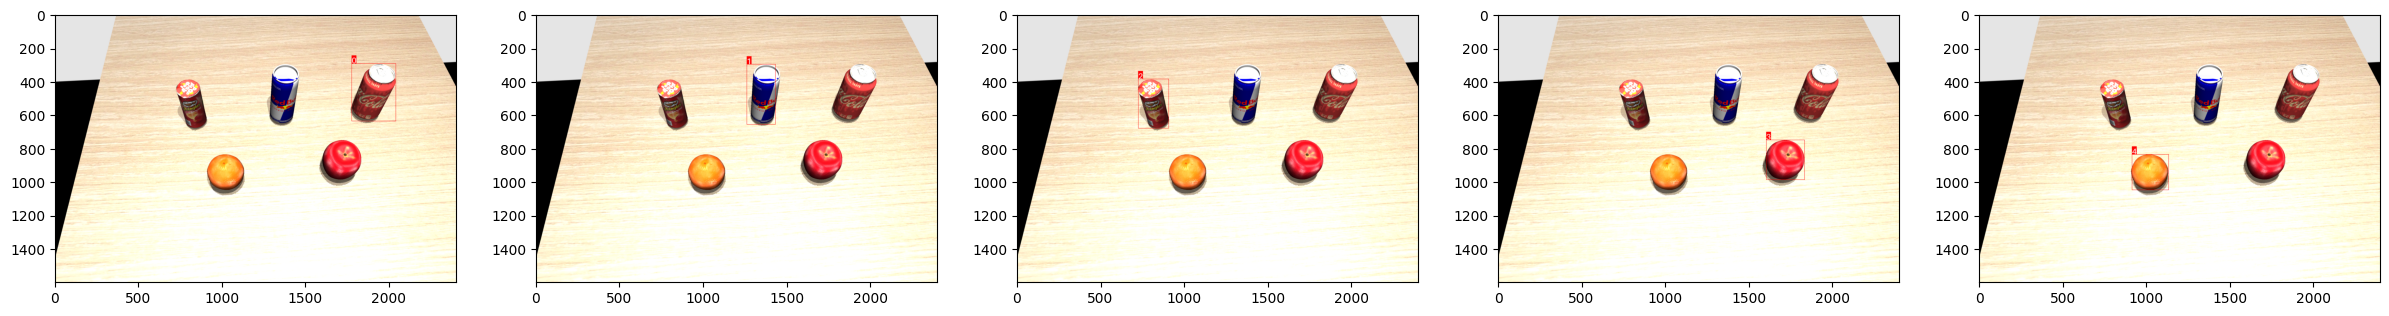

In [13]:
import asyncio
responses = []

plt.clf()
plt.figure(figsize=(30, 20))
for img, det_result in zip(images, [result]):

    boxes = det_result['boxes']
    
    conversations = []
    for i in range(len(boxes)):
        _img = img.copy()
        som_img = owlvit.draw_boxes(_img, [boxes[i]], labels=[str(i)])
        
        plt.subplot(1, len(boxes), i+1)
        plt.imshow(som_img)

        prompt = f"What is label of the object in the red bounding box?"

        conversations.append(
            ImageTextConversation(
            messages=[
                Message(role="system", text=SYSTEM_PROMPT_SOM),
                Message(role="user", text=prompt, image_path=som_img),
            ]
        )
        )

    tasks =[
         gpt4v_completion_async(
            conv,
            model="gpt-4o",
            response_model=ObjectLabelResponse,
            VERBOSE=False
        ) for conv in conversations
    ]
    # async som_imgs, prompts
    response_dict = await asyncio.gather(*tasks)

    responses.append(response_dict)

plt.show()

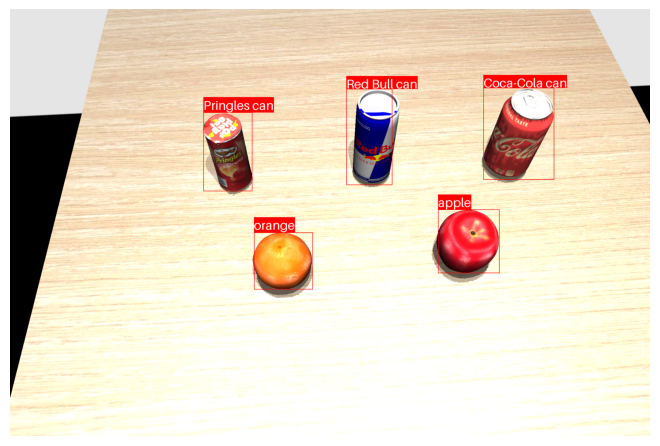

In [19]:
plt.clf()

img_copy = images[0].copy()

boxes = result['boxes']
relabels = [f"{response.label}" for i, response in enumerate(responses[0])]
final_image_overlayed = owlvit.draw_boxes(img_copy, boxes, relabels)

plt.imshow(final_image_overlayed)
plt.axis('off')

plt.subplots_adjust(hspace=0.1, top=1, bottom=0, left=0, right=1)
plt.tight_layout(pad=0)
plt.show()

In [17]:
relabels

['Coca-Cola can', 'Red Bull can', 'Pringles can', 'apple', 'orange']

## Choose which one to pick

In [24]:
from typing import Literal

class RobotActionCall(BaseModel):
    rationale: Optional[str] = Field(
        None, description="Detailed rationale for why the action is being called for."
    )
    action : Literal["pick", "place", "push", "pull", "rotate", "open", "close"] = Field(
        ..., description="Action to be performed on the object."
    )
    param : Optional[str] = Field(
        None, description="Exact label name for the bbox label names would be provided."
    )

    def __str__(self):
        return f"Action: {self.action}\nParameter: {self.param}\nRationale: {self.rationale}"


SYSTEM_PROMPT_ROBOT_ACTION_CALL = """
You are embodied in a simulated environment with a robotic arm. Your main task is to manipulate objects in the scene. Please provide the necessary actions and parameters to manipulate the objects in the scene.
""".strip()

In [25]:
# Step 1.2 : Define the conversation
conv = ImageTextConversation(
    messages=[
        Message(role="system", text=SYSTEM_PROMPT_ROBOT_ACTION_CALL),
        Message(role="user", text=f"Instruction : {instruction}\nObjects : {', '.join(relabels)}", image_path=final_image_overlayed),
    ]
)

# Step 1.3 : Run the GPT-4v model
robot_action_output_dict = gpt4v_completion(
    conv,
    model="gpt-4o",
    response_model=RobotActionCall,
)

print(robot_action_output_dict)

Action: pick
Parameter: Coca-Cola can
Rationale: The user is thirsty and needs a drink. The Coca-Cola can is a suitable option.


### Projection

In [182]:
# Crop pcd
for label,box in zip(labels,boxes_list):
    if label == object_tar:
        x_min = box[0]
        y_min = box[1]
        x_max = box[2]
        y_max = box[3]
        break

h,w = depth_img.shape
pcd_xy = pcd.reshape(h,w,3)
pcd_crop = pcd_xy[y_min:y_max, x_min:x_max]
pcd_crop = pcd_crop.reshape(-1, 3)
pcd_crop = pcd_crop[pcd_crop[:,2] > (table_z+0.03)]

# make Projection
proj = np.ones((400, 400, 3), dtype=np.uint8) * 255
for p in pcd_crop:
    xy = [0,0]
    xy[0] = int((p[0] - 0.5) / 0.6 * 400)
    xy[1] = int((p[1] + 0.3) / 0.6 * 400)
    cv2.circle(proj, (xy[0],xy[1]), 5, (0, 0, 0), -1)
cv2.imwrite('../before_transformation.png', proj)
print ("Ready.")
proj_img = plt.imread('../before_transformation.png')

Ready.


### Circle detection by Hough Transform

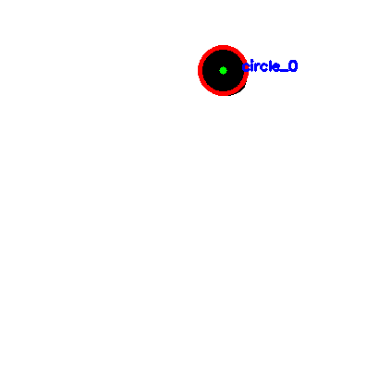

In [183]:
src = cv2.imread("../before_transformation.png")
dst = src.copy()
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1 = 250, param2 = 10, minRadius = 16, maxRadius = 30)
circles = np.uint16(np.around(circles))
circles = circles.reshape(-1,3)
sorted_idx = np.argsort(circles[:,1])
circles = circles[sorted_idx]
if len(circles) >1:
    print("Too many circles detected")
else:
    for idx,i in enumerate(circles):
        cv2.circle(dst, (i[0], i[1]), 4, (0, 255, 0), -1)
        cv2.circle(dst,(i[0], i[1]), i[2], (0, 0, 255), 3)
        cv2.putText(dst,'circle_{}'.format(idx),(i[0]+20, i[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
    cv2.imwrite("../after_transformation.png", dst)
    cv2.imshow("img", dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = plt.imread("../after_transformation.png")
    plt.axis('off')
    plt.imshow(img)



### Find grasp positon

In [184]:
img = plt.imread("../before_transformation.png")
h,w = img.shape[0:2]
grasp_pixel = (circles[0][0],circles[0][1])
grasp_x = 0.6 + 0.6 * grasp_pixel[0] / w 
grasp_y = -0.3 + 0.6 * grasp_pixel[1] / h

# nearest point search
nearest_point_idx = np.argmin(np.linalg.norm(pcd_crop[:,0:2] - np.array([[grasp_x, grasp_y]]*len(pcd_crop)), axis=1))
print("Obejct : ",pcd_crop[nearest_point_idx])
grasping_point = pcd_crop[nearest_point_idx].copy()
grasping_point[0] -= 0.02 #magic number
if object_tar in ['an orange','an apple']:    
    grasping_point[2] -= 0.02 #magic number
else:
    grasping_point[2] = np.average([grasping_point[2],table_z])
print("Grasping point: ",grasping_point)

Obejct :  [ 0.87647342 -0.19733118  0.86683173]
Grasping point:  [ 0.85647342 -0.19733118  0.80345487]


### Render grasp point

MODE: window
Ready.


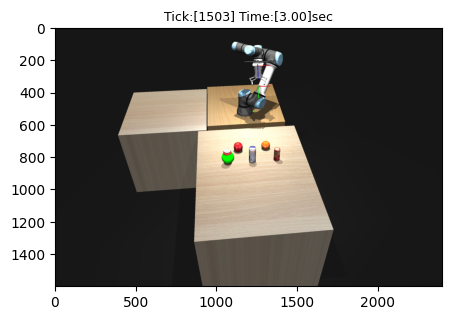

In [185]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)
render_dt = 1./30.
p_time = env.get_p_body('ur_base')
p_time[2] += 0.5
t_s = time.perf_counter()
t_sim_start = t_s
while env.is_viewer_alive():
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=init_joint_value, ctrl_idxs=env.idxs_step)
        step_gripper(env,command="open")
    if time.perf_counter() - t_s >= render_dt:
        t_s += render_dt
        env.plot_T(p=env.get_p_body('ur_base'),R=env.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_T(p=p_time,R=env.get_R_body('ur_base'),label="simtime=[%.1f],realtime=[%.1f]"%(env.get_sim_time(),time.perf_counter()-t_sim_start),PLOT_AXIS=False)
        env.plot_T(p=env.get_p_body('ur_camera_center'),R=env.get_R_body('ur_camera_center'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.plot_sphere(p=grasping_point, r=0.05, rgba=np.array([0, 1, 0, 1]))
        env.plot_T(p=env.get_p_body('ur_tcp_link'),R=env.get_R_body('ur_tcp_link'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env.render()
    if env.get_sim_time() > 3:
        img = env.grab_image()
        break
    
env.close_viewer()
print ("Ready.")
# Plot the final scene and egocentric images
plt.figure(figsize=(5,4)); plt.imshow(img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
plt.close()

### Solve IK (grasping)

In [186]:

xml_path_fw = '../asset/ur5e/realworld.xml'
env_fw = ManipulatorAgent(rel_xml_path=xml_path_fw,VERBOSE=False, MODE=MODE)
env_fw.reset()
env_fw.forward(q=init_joint_value, joint_idxs=env.idxs_forward)

if object_tar in ['an orange', 'an apple']:
    R_trgt = rpy2r(np.radians([-90, 0, 90])) # Rotation fixed
else:
    R_trgt = rpy2r(np.radians([-180, 0, 90])) # Rotation fixed

q_init = np.array(init_joint_value)
q_setup = np.array([-0.00506145, -2.04203522,  2.07694181, -0.06283185,  1.58824962,  0.03490659])
q_traj = []
q_traj.append(q_init)
q_traj.append(q_setup)
p_grasp = grasping_point
p_pregrasp = p_grasp + np.array([0,0,0.2])
p_anchor = []
p_anchor.append(p_pregrasp)
p_anchor.append(p_grasp)
for i in range(len(p_anchor)):
    q_point, ik_done = env_fw.solve_ik_repel(
        body_name='ur_tcp_link',p_trgt=p_anchor[i],R_trgt=R_trgt,
        IK_P=True,IK_R=True, q_init=q_traj[i+1],idxs_forward=env_fw.idxs_forward, idxs_jacobian=env_fw.idxs_jacobian,
        RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=10000)
    q_traj.append(q_point)
    if ik_done == False:
        print("IK does not solved.")

print("IK solved.")



MODE: window
IK solved.


### Solve IK (placing)

In [187]:
q_init_pl = q_traj[-1].copy()
p_place = np.array([p_grasp[1],-p_grasp[0],p_grasp[2]])
p_place[0] = p_grasp[1]
p_place[1] = -p_grasp[0]
p_place[2] = p_grasp[2]
p_preplace =  p_place.copy() + np.array([0, 0, 0.1])
q_traj_pl = []
q_traj_pl.append(q_init_pl)

q_prepreplace = q_traj[-2].copy()
q_traj_pl.append(q_prepreplace)
q_preplace = q_prepreplace.copy()
q_preplace[0] = q_prepreplace[0] + d2r(-90)
q_traj_pl.append(q_preplace)

env.forward(q=q_preplace, joint_idxs=env.idxs_forward)
R_trgt_pl = env.get_R_body('ur_tcp_link')


q_place, ik_done = env_fw.solve_ik_repel(
    body_name='ur_tcp_link',p_trgt=p_place,R_trgt=R_trgt_pl,
    IK_P=True,IK_R=True, q_init=q_preplace,idxs_forward=env_fw.idxs_forward, idxs_jacobian=env_fw.idxs_jacobian,
    RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-3, stepsize = 2.0, repulse=30, BREAK_TICK=10000)
q_traj_pl.append(q_place)
if ik_done == False:
    print("IK does not solved.")
else:
    print("IK solved.")

IK solved.


### Check IK Result

In [188]:

env_fw.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env_fw.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env_fw.reset()
env_fw.forward(q=init_joint_value, joint_idxs=env_fw.idxs_forward)
tick = 0
while env_fw.is_viewer_alive():
    if tick < len(q_traj):
        env_fw.forward(q=q_traj[tick], joint_idxs=env_fw.idxs_forward)
        env_fw.plot_T(p=env_fw.get_p_body('ur_base'),R=env_fw.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        for i in p_anchor:
            env_fw.plot_sphere(p=i, r=0.005, rgba=[0, 1, 0, 1])
        env_fw.plot_sphere(p=grasping_point, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.plot_sphere(p=p_place, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.render()
        time.sleep(0.5)
        tick += 1   
    else:
        env_fw.forward(q=q_traj_pl[tick-len(q_traj)], joint_idxs=env_fw.idxs_forward)
        env_fw.plot_T(p=env_fw.get_p_body('ur_base'),R=env_fw.get_R_body('ur_base'),PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025)
        env_fw.plot_sphere(p=grasping_point, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.plot_sphere(p=p_place, r=0.03, rgba=np.array([1, 0, 0, 1]))
        env_fw.render()
        time.sleep(0.5)
        tick += 1
        if tick >= len(q_traj_pl)+len(q_traj):
            break
env_fw.close_viewer()

MODE: window


### Interplation & Smoothing (grasping)

In [189]:
""" Set params"""
HZ = 50
dt = 1./HZ 
t_i = 2. # Time increasing rate when the optimization failed.

q_anchors = np.array(q_traj)
N,D = q_anchors.shape
print(N,D)
q_lowers = d2r([-360.]*D)
q_uppers = d2r([360.]*D)

vel_limit = d2r(120.)
acc_limit = d2r(60.)
jerk_limit = d2r(180.)


""" Interpolate and smooth """

times, traj_interp, traj_smt, times_anchor = interpolate_and_smooth_nd(
    anchor      = q_anchors,
    time_increasing_rate = t_i,
    HZ          = HZ,
    vel_init    = 0.0, 
    vel_final   = 0.0, 
    x_lowers    = q_lowers,
    x_uppers    = q_uppers,
    vel_limit   = vel_limit,
    acc_limit   = acc_limit,
    jerk_limit  = jerk_limit,
    verbose     = True,
)


4 6
Try smoothing for 1.0 seconds...
Optimization failed at 1.0 seconds.
Try smoothing for 3.0 seconds...
Optimization failed at 3.0 seconds.
Try smoothing for 5.0 seconds...
Optimization failed at 5.0 seconds.
Try smoothing for 7.0 seconds...
Optimization is successful at 7.0 seconds.


### Interplation & Smoothing (placing)

In [190]:
""" Set params"""
HZ = 50
dt = 1./HZ 
t_i = 2. # Time increasing rate when the optimization failed.

q_anchors_pl = np.array(q_traj_pl)
N,D = q_anchors_pl.shape
print(N,D)
q_lowers = d2r([-360.]*D)
q_uppers = d2r([360.]*D)

vel_limit = d2r(120.)
acc_limit = d2r(60.)
jerk_limit = d2r(180.)


""" Interpolate and smooth """

times_pl, traj_interp_pl, traj_smt_pl, times_anchor_pl = interpolate_and_smooth_nd(
    anchor      = q_anchors_pl,
    time_increasing_rate = t_i,
    HZ          = HZ,
    vel_init    = 0.0, 
    vel_final   = 0.0, 
    x_lowers    = q_lowers,
    x_uppers    = q_uppers,
    vel_limit   = vel_limit,
    acc_limit   = acc_limit,
    jerk_limit  = jerk_limit,
    verbose     = True,
)

4 6
Try smoothing for 1.0 seconds...
Optimization failed at 1.0 seconds.
Try smoothing for 3.0 seconds...
Optimization failed at 3.0 seconds.
Try smoothing for 5.0 seconds...
Optimization failed at 5.0 seconds.
Try smoothing for 7.0 seconds...
Optimization is successful at 7.0 seconds.


### Real-time simulation

MODE: window


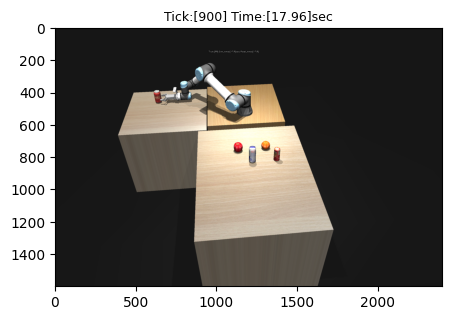

In [191]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=3.5,elevation=-40,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=init_joint_value, joint_idxs=env.idxs_forward)


render_dt = 1./30.
grasping_duration = 2.0
grasping_duration_tick = int(grasping_duration * HZ)

step_gripper(env,'open')
t_s = time.perf_counter()
t_sim_start = t_s

# move to grasping point
ctrl_tick = 0
while ctrl_tick < len(traj_smt)-1:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=traj_smt[ctrl_tick], ctrl_idxs=env.idxs_step,nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()
        
# grasp
ctrl_tick = 0
while ctrl_tick < grasping_duration_tick:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        step_gripper(env, 'close',nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()

# placing
ctrl_tick = 0
while ctrl_tick < len(traj_smt_pl)-1:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        env.step(ctrl=traj_smt_pl[ctrl_tick], ctrl_idxs=env.idxs_step,nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()


# ungrasp
ctrl_tick = 0
while ctrl_tick < grasping_duration_tick:
    if env.get_sim_time() <= time.perf_counter() - t_sim_start:
        step_gripper(env, 'open',nstep=int(env.HZ/HZ))
        ctrl_tick += 1
    if time.perf_counter() - t_s >= render_dt:
        p_t = env.get_p_body("ur_base") + [0,-.3,0.6]
        t_s += render_dt
        env.plot_T(p=p_t,R=np.eye(3,3),PLOT_AXIS=False,
                    label="Tick:[%d] Sim_time:[%.1f]sec Real_time:[%.1f]"%(ctrl_tick,env.get_sim_time(),time.perf_counter()-t_sim_start))
        env.plot_contact_info(VERBOSE=True,must_include_prefix=['ur_rg2_gripper_finger1_finger_tip_link','ur_rg2_gripper_finger2_finger_tip_link'])
        env.render()

scene_img = env.grab_image()
time.sleep(1)
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
env.close_viewer()
